#Import

In [1]:
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
# import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda:0


# Activation Function

In [2]:
class Swish(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(x)

class Max(nn.Module):
    def forward(self, x):

        return torch.max(torch.zeros_like(x), x**3)

# 사용 예시
activation = torch.tanh
activation_ = Swish()

#Build Network

In [3]:
M = 64
selu = Swish()

T = True
F = False

class Net_Torsion(nn.Module):
    def __init__(self):
        super(Net_Torsion, self).__init__()
        torch.manual_seed(1234) # Fix Initial_Parameter
        self.hidden_layer1 = nn.Linear(4,M, bias = T)
        torch.manual_seed(1234)
        self.hidden_layer2 = nn.Linear(M,M, bias = T)
        torch.manual_seed(1234)
        self.hidden_layer3 = nn.Linear(M,M, bias = T)
        torch.manual_seed(1234)
        self.hidden_layer4 = nn.Linear(M,M, bias = T)
        torch.manual_seed(1234)
        self.output_layer = nn.Linear(M,1, bias = T)

    def forward(self, x, loc, max, std):
        inputs = torch.cat([x,loc,max,std],axis=1)
        layer1_out = activation(self.hidden_layer1(inputs))
        layer2_out = activation(self.hidden_layer2(layer1_out))
        layer3_out = activation(self.hidden_layer3(layer2_out))
        layer4_out = activation(self.hidden_layer4(layer3_out))
        output = self.output_layer(layer4_out)

        return output

# solution

In [11]:
 # Gaussian function
def gaussian(s, x0, sigma):
    return np.exp(-((s - x0) ** 2) / (2 * sigma ** 2))

# Inner integral
def inner_integral(x):
    result, _ = quad(lambda s: T0 * gaussian(s, x0, sigma), 0, x)
    return result

# Outer integral
def outer_integral(x):
    result, _ = quad(inner_integral, 0, x)
    return result

# Final function theta(x)
def theta(x):
    integral_part = -outer_integral(x)
    remaining_integral, _ = quad(lambda s: T0 * gaussian(s, x0, sigma), 0, 1)
    return integral_part + x * remaining_integral

In [12]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt

# Constants
# T0 = 4
# x0 = 0.8
# sigma = 0.01

theta_values_ = []

for T0 in [1,2,3,4,5,6,7,8,9,10]:
    for x0 in [0.5, 0.6, 0.7, 0.8, 0.9]:
        for sigma in [ 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
            x_values = np.linspace(0, 1, 100)
            for x in x_values:
                theta_values_.append(theta(x))
            # theta_values = [theta(x) for x in x_values]

# print(theta_values)

# Plot
# plt.plot(x_values, theta_values, label=r'$\theta(x)$')
# plt.xlabel('x')
# plt.ylabel(r'$\theta(x)$')
# plt.legend()
# plt.grid(True)
# plt.show()

#set PDE,residual

In [13]:
L = 100  ## set unit size

r_out = 0.05*100/L
r_in = 0.03*100/L
delta_r = 0.02*100/L

G = (80*10**9)/((100/L)**2)
J = (torch.pi/32)*((r_out**4)-(r_in**4))

T_ = 0

N = 1 ## variable scaling factor

In [14]:
def f(x, loc, max, std,  net):
    u = net(x,loc,max,std)

    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]

    pde = -u_xx - max*torch.exp(-((x-loc)**2)/(2*std**2))

    return pde


# Boundary Condition

In [15]:
H = 1 ## height scaling

##------------------------------Boundary data point-------------------------------------------##

x_0 = np.zeros((10000,1))
x_N = np.ones((10000,1))*(100/L)*N

bdy_loc_collocation = np.random.uniform(low = (50/L)*N, high = (90/L)*N, size = (10000,1))
bdy_std_collocation = np.random.uniform(low = 0.2, high = 1, size = (10000,1))
bdy_max_collocation = np.random.uniform(low = 1, high = 10, size = (10000,1))

##---------------------------------Condition Label--------------------------------##

u_x0 =  np.zeros((10000,1))
u_xN =  np.zeros((10000,1))

##--------------------------------------------------------------------------##

C_x_0 = Variable(torch.from_numpy(x_0).float(), requires_grad=True).to(device)
C_x_N = Variable(torch.from_numpy(x_N).float(), requires_grad=True).to(device)
pt_u_x0 = Variable(torch.from_numpy(u_x0).float(), requires_grad=False).to(device) ##
pt_u_xN = Variable(torch.from_numpy(u_xN).float(), requires_grad=False).to(device) ##

pt_bdy_loc = Variable(torch.from_numpy(bdy_loc_collocation).float(), requires_grad=False).to(device)
pt_bdy_std = Variable(torch.from_numpy(bdy_std_collocation).float(), requires_grad=False).to(device)
pt_bdy_max = Variable(torch.from_numpy(bdy_max_collocation).float(), requires_grad=False).to(device)

#Define Diff

In [16]:
def dx(x, loc, max, std, net):
    u = net(x,loc,max,std)

    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]

    return u_x

#Set Observer Point

In [17]:
x_D = np.linspace(0 ,1*(100/L)*N , 1000).reshape(1000,1)

pt_x = Variable(torch.from_numpy(x_D).float(), requires_grad = False).to(device)

# pt_x

#loss,optimize

In [18]:
import torch
import torch.nn.init as init

### (2) Model
mse_cost_function = torch.nn.MSELoss()

net_T = Net_Torsion()
net_T = net_T.to(device)

optimizer = torch.optim.Adam(net_T.parameters(),lr=0.001)

#Train

In [19]:
iter = []
error = []

loss1 = []
loss2 = []
loss3 = []

In [20]:
previous_validation_loss = 99999999.0
gap3 = 1
epoch = 0
iterations = 20000
x_values_ = np.linspace(0, 1, 100).reshape(100,1)
x_values_ = Variable(torch.from_numpy(x_values_).float(), requires_grad=False).to(device)

loss = 1

for epoch in range(iterations):
# while gap3 > 0.053 and epoch <800:
    optimizer.zero_grad()

##-------------------------------Condition predict output------------------------------------##

    net_x0_out = net_T(C_x_0, pt_bdy_loc, pt_bdy_max, pt_bdy_std)
    net_dxN_out = dx(C_x_N, pt_bdy_loc, pt_bdy_max, pt_bdy_std, net_T)

# ------------------------------------Condition Loss-----------------------------------------##
    mse_x0t = mse_cost_function(net_x0_out, pt_u_x0)
    mse_xNt = mse_cost_function(net_dxN_out, pt_u_xN)

##------------------------------------Set Interior Domain-----------------------------------------##
    if epoch % 1000 == 0:
        x_collocation = np.random.uniform(low = 0.00*N, high = (100/L)*N, size=(100000,1))
        loc_collocation = np.random.uniform(low = (50/L)*N, high = (90/L)*N, size = (100000,1))
        std_collocation = np.random.uniform(low = 0.2, high = 1, size = (100000,1))
        max_collocation = np.random.uniform(low = 1, high = 10, size = (100000,1))
        all_zeros = np.zeros((100000,1))

        pt_x_col = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
        pt_loc_col = Variable(torch.from_numpy(loc_collocation).float(), requires_grad=True).to(device)
        pt_std_col = Variable(torch.from_numpy(std_collocation).float(), requires_grad=True).to(device)
        pt_max_col = Variable(torch.from_numpy(max_collocation).float(), requires_grad=True).to(device)

        pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)

##------------------------------------Compute Loss-----------------------------------------##
### f(data, loc, max, std, net)
    f_out = f(pt_x_col, pt_loc_col, pt_max_col, pt_std_col, net_T)
    mse_f = mse_cost_function(f_out, pt_all_zeros)

    loss = 2*mse_x0t + 2*mse_xNt + 1*mse_f

##------------------------------------Optimize Loss-----------------------------------------##

    loss.backward()
    optimizer.step()
    epoch += 1

##----------------------------Result-----------------------------##
    if (epoch) % 50 == 1:
        ms_u = []

        for T0 in [1,2,3,4,5,6,7,8,9,10]:
            for x0 in [0.5, 0.6, 0.7, 0.8, 0.9]:
                for sigma in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
                    T0_ = np.ones((100,1))*T0
                    x0_ = np.ones((100,1))*x0
                    sigma_ = np.ones((100,1))*sigma

                    T0_ = Variable(torch.from_numpy(T0_).float(), requires_grad=False).to(device)
                    x0_ = Variable(torch.from_numpy(x0_).float(), requires_grad=False).to(device)
                    sigma_ = Variable(torch.from_numpy(sigma_).float(), requires_grad=False).to(device)

                    pt_u0 = net_T(x_values_, x0_, T0_, sigma_)
                    u = pt_u0.data.cpu().numpy()
                    for i in range(len(u)):
                        ms_u.append(u[i][0])

        t1 = torch.tensor(theta_values_, dtype=torch.float32)
        t2 = torch.tensor(ms_u, dtype=torch.float32)

        error_ = torch.sqrt(((t1-t2)**2).mean()/(t1**2).mean())
        # pt_u3 = pt_x*1*net_T(pt_x)/H
        # gap3 = torch.sqrt(((Solution - pt_u3)**2).mean())/torch.sqrt((Solution**2).mean())

        iter.append(epoch)
        error.append((error_).cpu().detach().numpy())
        # loss1.append(mse_xNt.item())
        # loss2.append(mse_f.item())
        # loss3.append(mse_f_refine.item())

    if (epoch) % 100 == 1:
        print("-----------------------------------------------------------------------------")
        print("Epoch:",epoch)
        print("Error: ",error_)
        # print("u(0) loss: ",mse_x0t.item())
        # print("du(L)/dx loss :", mse_xNt.item())
        # print("Residual Loss :", mse_f.item())
        # print(loss)

-----------------------------------------------------------------------------
Epoch: 1
Error:  tensor(0.9848)
-----------------------------------------------------------------------------
Epoch: 101
Error:  tensor(0.2460)
-----------------------------------------------------------------------------
Epoch: 201
Error:  tensor(0.1198)
-----------------------------------------------------------------------------
Epoch: 301
Error:  tensor(0.1951)
-----------------------------------------------------------------------------
Epoch: 401
Error:  tensor(0.0849)
-----------------------------------------------------------------------------
Epoch: 501
Error:  tensor(0.0763)
-----------------------------------------------------------------------------
Epoch: 601
Error:  tensor(0.0738)


KeyboardInterrupt: 

#Plotting Prediction

In [21]:
torch.tensor(1.0, requires_grad=True)

x_values = np.linspace(0, 1, 100)
x_values_ = np.linspace(0, 1, 100).reshape(100,1)
x_values_ = Variable(torch.from_numpy(x_values_).float(), requires_grad=False).to(device)

error_list=[]

N_samples = 10


# T0:
T0_list = np.random.uniform(1, 10, size=N_samples)

# x0:
x0_list = np.random.uniform(0.5, 0.9, size=N_samples)

# sigma:
sigma_list = np.random.uniform(0.2, 1.0, size=N_samples)

for T0 in T0_list:
    for x0 in x0_list:
        for sigma in sigma_list:
            theta_values = []
            ms_u = []

            T0_ = np.ones((100,1))*T0
            x0_ = np.ones((100,1))*x0
            sigma_ = np.ones((100,1))*sigma

            T0_ = Variable(torch.from_numpy(T0_).float(), requires_grad=False).to(device)
            x0_ = Variable(torch.from_numpy(x0_).float(), requires_grad=False).to(device)
            sigma_ = Variable(torch.from_numpy(sigma_).float(), requires_grad=False).to(device)

            pt_u0 = net_T(x_values_, x0_, T0_, sigma_)
            u = pt_u0.data.cpu().numpy()
            for i in range(len(u)):
                ms_u.append(u[i][0])

            for x in x_values:
                theta_values.append(theta(x))

            # numpy array 변환
            A = np.array(theta_values)
            B = np.array(ms_u)

            # L2 norm 계산
            rel_L2 = np.linalg.norm(A - B) / np.linalg.norm(A)

            error_list.append(rel_L2)


In [ ]:
error_list

[np.float64(0.007160975271969245),
 np.float64(0.0069462266882632856),
 np.float64(0.008078045845724599),
 np.float64(0.007863158034828245),
 np.float64(0.007502556738465805),
 np.float64(0.007105913869174676),
 np.float64(0.007566907233530205),
 np.float64(0.007577492028701283),
 np.float64(0.007291522313899734),
 np.float64(0.006384515609421929),
 np.float64(0.006982294994939432),
 np.float64(0.00683482741622414),
 np.float64(0.007134650647668342),
 np.float64(0.0073848900364593874),
 np.float64(0.007207805771642517),
 np.float64(0.006416405748995151),
 np.float64(0.007243551115978835),
 np.float64(0.00724933247795107),
 np.float64(0.007082881983100248),
 np.float64(0.006455075864993771),
 np.float64(0.005951454690041897),
 np.float64(0.005644379181421561),
 np.float64(0.006885080879434606),
 np.float64(0.006397970265081196),
 np.float64(0.005929189988892012),
 np.float64(0.0065576233026607205),
 np.float64(0.006009911805165339),
 np.float64(0.006023296697619762),
 np.float64(0.00567

In [23]:
arr = np.array(error_list)

mean_val = np.mean(arr)
std_val  = np.std(arr)
max_val  = np.max(arr)
min_val  = np.min(arr)

max_idx = np.argmax(arr)
min_idx = np.argmin(arr)

print("max_err:", arr[max_idx], "max_index:", max_idx)
print("min_err:", arr[min_idx], "min_index:", min_idx)

print("mean_err:", mean_val)
print("err_std:", std_val)
# print("max_err:", max_val)
# print("min_err:", min_val)

max_err: 0.36463264416797697 max_index: 901
min_err: 0.0026446893730568176 min_index: 881
mean_err: 0.04780124932363239
err_std: 0.03574444532241368


In [ ]:
# ((theta_values-ms_u)**2).mean()

t1 = torch.tensor(theta_values, dtype=torch.float32)
t2 = torch.tensor(ms_u, dtype=torch.float32)

error = torch.sqrt(((t1-t2)**2).mean()/(t1**2).mean())
error

tensor(0.0084)

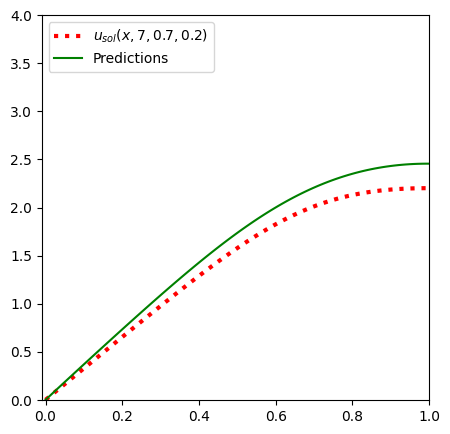

In [25]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure(figsize = (5,5)) #피규어 사이즈
ax = fig.add_subplot()

x_ = np.linspace(0,100/L,100)  #보여줄 x 축 범위

T0 = 7
x0 = 0.7
sigma = 0.2

tmp_loc = x0*torch.ones(100,1).to(device)
tmp_max = T0*torch.ones(100,1).to(device)
tmp_std = sigma*torch.ones(100,1).to(device)

tmp_theta_values2 = []
for x in x_values:
    tmp_theta_values2.append(theta(x))

ms_x = np.meshgrid(x_)

x_ = np.ravel(ms_x).reshape(-1,1)

pt_x0 = Variable(torch.from_numpy(x_).float(), requires_grad=False).to(device)

pt_u0 = N*net_T(N*pt_x0, tmp_loc, tmp_max, tmp_std)

# print(pt_u0)

u = (1)*pt_u0.data.cpu().numpy()


ms_u2 = []

for i in range(len(u)):
  ms_u2.append(u[i][0])
  # print(u[i][0])

ns_u2 = []

ns_u2.append(ms_u2)


plt.plot(ms_x[0],tmp_theta_values2,'r:',linewidth = 3, label=r"$u_{sol}(x, 7, 0.7, 0.2)$")
surf3 = ax.plot(ms_x[0],ns_u2[0],'g',label="Predictions")

plt.ylim(-0.005, 4)
plt.xlim(-0.01,100/L)
# plt.yscale('log')
plt.legend(loc = "upper left")
plt.show()

# print(u.max())

#Plot Learning Curve

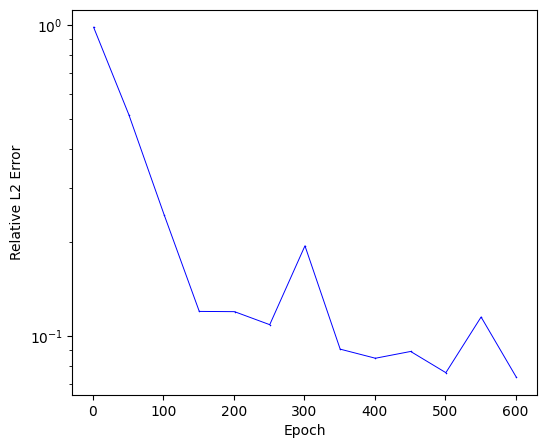

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.plot(iter, error ,color = 'blue', marker='x',markersize=0.5,linewidth="0.7")

# plt.plot(iter, loss2 ,color = 'red', marker='x',markersize=0.5,linewidth="0.7")


plt.yscale('log')
# plt.legend(loc = 'lower left')

plt.xlabel('Epoch')
# plt.ylabel('ODE Loss')
plt.ylabel('Relative L2 Error')
plt.show()
plt.close()